In [2]:
import transformers
print(transformers.__version__)


4.57.1


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\91706\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\91706\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


Dataset shape: (10000, 5)
Cleaning abstracts...


100%|██████████| 10000/10000 [00:02<00:00, 3517.68it/s]


Assigning sentiment labels...


100%|██████████| 10000/10000 [00:10<00:00, 918.77it/s]


sentiment
positive    6939
negative    2064
neutral      997
Name: count, dtype: int64

Logistic Regression Results:
               precision    recall  f1-score   support

    negative       0.59      0.61      0.60       411
     neutral       0.36      0.56      0.44       216
    positive       0.87      0.79      0.83      1373

    accuracy                           0.73      2000
   macro avg       0.61      0.65      0.62      2000
weighted avg       0.76      0.73      0.74      2000

Accuracy: 0.726

Random Forest Results:
               precision    recall  f1-score   support

    negative       0.88      0.12      0.21       411
     neutral       0.69      0.34      0.46       216
    positive       0.74      0.98      0.84      1373

    accuracy                           0.74      2000
   macro avg       0.77      0.48      0.50      2000
weighted avg       0.76      0.74      0.67      2000

Accuracy: 0.7365


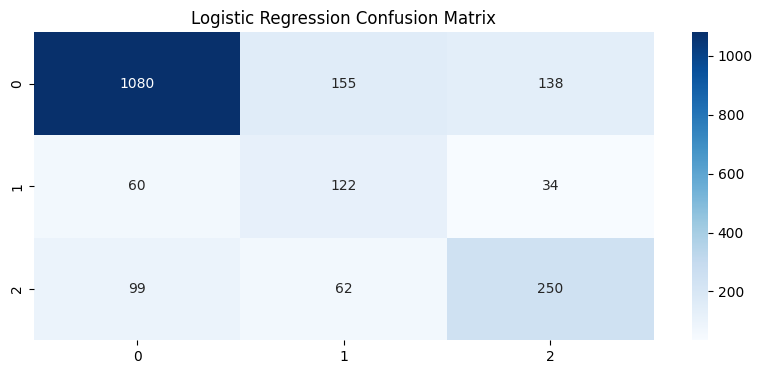

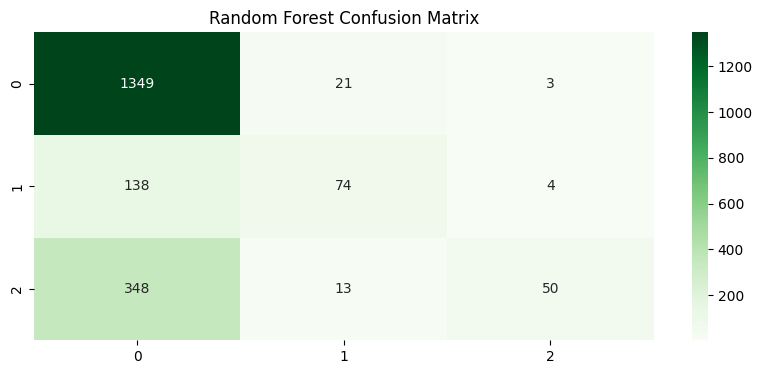

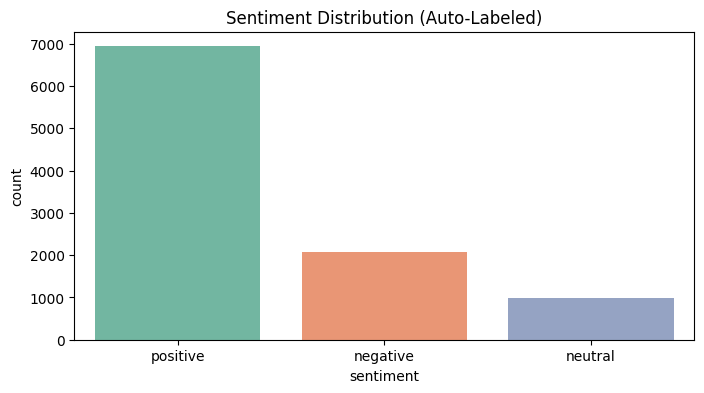


Top words contributing to each sentiment:
negative: problem, decay, weak, collisions, problems, negative, error, decays, critical, low
neutral: inequalities, characterize, heavy, bodies, paper, anomalous, generated, asymptotics, mechanics, generating
positive: energy, effective, well, strong, free, dynamics, number, certain, positive, solution

✅ TF-IDF models saved successfully!

🤖 Loading BERT for Sentiment Classification...



Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`



✅ BERT Ready for Prediction (NO TRAINING REQUIRED)


In [1]:
# ===============================
# Research Abstract Sentiment Analysis (TF-IDF + ML + BERT)
# Author: Sparshi Jain
# ===============================

import pandas as pd
import numpy as np
import re
import nltk, pickle, warnings
import matplotlib.pyplot as plt
import seaborn as sns
from bs4 import BeautifulSoup
from nltk.corpus import stopwords
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from tqdm import tqdm

warnings.filterwarnings("ignore")

# -----------------------------------------
# 1️⃣ NLTK Setup
# -----------------------------------------
nltk.download("stopwords")
nltk.download("vader_lexicon")
stop_words = set(stopwords.words("english"))
sia = SentimentIntensityAnalyzer()

# -----------------------------------------
# 2️⃣ Load Dataset
# -----------------------------------------
df = pd.read_csv(r"C:\Users\91706\OneDrive\Attachments\Desktop\sen\arxiv_sample.csv")
df = df.sample(10000, random_state=42).reset_index(drop=True)
print("Dataset shape:", df.shape)

# -----------------------------------------
# 3️⃣ Text Cleaning
# -----------------------------------------
def clean_text(text):
    if not isinstance(text, str):
        return ""
    text = BeautifulSoup(text, "html.parser").get_text()
    text = text.lower()
    text = re.sub(r"http\S+|www\S+|https\S+", "", text)
    text = re.sub(r"[^a-z\s]", "", text)
    words = [w for w in text.split() if w not in stop_words and len(w) > 2]
    return " ".join(words)

tqdm.pandas()
print("Cleaning abstracts...")
df["clean_abstract"] = df["abstract"].progress_apply(clean_text)

# -----------------------------------------
# 4️⃣ Auto Sentiment Labeling (VADER)
# -----------------------------------------
def get_sentiment(text):
    score = sia.polarity_scores(text)["compound"]
    if score >= 0.05:
        return "positive"
    elif score <= -0.05:
        return "negative"
    else:
        return "neutral"

print("Assigning sentiment labels...")
df["sentiment"] = df["clean_abstract"].progress_apply(get_sentiment)
print(df["sentiment"].value_counts())

# -----------------------------------------
# 5️⃣ TF-IDF Vectorization
# -----------------------------------------
tfidf = TfidfVectorizer(max_features=5000, ngram_range=(1,2))
X = tfidf.fit_transform(df["clean_abstract"])
y = df["sentiment"]

# -----------------------------------------
# 6️⃣ Train-Test Split
# -----------------------------------------
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# -----------------------------------------
# 7️⃣ Logistic Regression Model
# -----------------------------------------
lr_model = LogisticRegression(max_iter=500, class_weight="balanced")
lr_model.fit(X_train, y_train)
y_pred_lr = lr_model.predict(X_test)

print("\nLogistic Regression Results:\n", classification_report(y_test, y_pred_lr))
print("Accuracy:", accuracy_score(y_test, y_pred_lr))

# -----------------------------------------
# 8️⃣ Random Forest Model
# -----------------------------------------
rf_model = RandomForestClassifier(n_estimators=400, random_state=42, class_weight="balanced")
rf_model.fit(X_train, y_train)
y_pred_rf = rf_model.predict(X_test)

print("\nRandom Forest Results:\n", classification_report(y_test, y_pred_rf))
print("Accuracy:", accuracy_score(y_test, y_pred_rf))

# -----------------------------------------
# 9️⃣ Confusion Matrices
# -----------------------------------------
plt.figure(figsize=(10,4))
sns.heatmap(confusion_matrix(y_test, y_pred_lr, labels=["positive","neutral","negative"]),
            annot=True, cmap="Blues", fmt='d')
plt.title("Logistic Regression Confusion Matrix")
plt.show()

plt.figure(figsize=(10,4))
sns.heatmap(confusion_matrix(y_test, y_pred_rf, labels=["positive","neutral","negative"]),
            annot=True, cmap="Greens", fmt='d')
plt.title("Random Forest Confusion Matrix")
plt.show()

# -----------------------------------------
# 🔟 Sentiment Distribution Dashboard
# -----------------------------------------
plt.figure(figsize=(8,4))
sns.countplot(x="sentiment", data=df, palette="Set2")
plt.title("Sentiment Distribution (Auto-Labeled)")
plt.show()

# -----------------------------------------
# 1️⃣1️⃣ Explainability (Top TF-IDF words)
# -----------------------------------------
feature_names = np.array(tfidf.get_feature_names_out())
classes = lr_model.classes_
top_words = {}

for i, class_label in enumerate(classes):
    coef = lr_model.coef_[i]
    top_idx = coef.argsort()[-10:][::-1]
    top_words[class_label] = feature_names[top_idx]

print("\nTop words contributing to each sentiment:")
for sentiment, words in top_words.items():
    print(f"{sentiment}: {', '.join(words)}")

# -----------------------------------------
# 1️⃣2️⃣ Save TF-IDF & ML Models
# -----------------------------------------
with open("tfidf_vectorizer.pkl", "wb") as f:
    pickle.dump(tfidf, f)

with open("logistic_regression_model.pkl", "wb") as f:
    pickle.dump(lr_model, f)

with open("random_forest_model.pkl", "wb") as f:
    pickle.dump(rf_model, f)

print("\n✅ TF-IDF models saved successfully!")

# ===========================================================
# ✅ BERT (Pretrained — no training, instant result)
# ===========================================================
print("\n🤖 Loading BERT for Sentiment Classification...")

from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch

bert_model_name = "nlptown/bert-base-multilingual-uncased-sentiment"

bert_tokenizer = AutoTokenizer.from_pretrained(bert_model_name)
bert_model = AutoModelForSequenceClassification.from_pretrained(bert_model_name)

def bert_predict(text):
    tokens = bert_tokenizer(text, return_tensors="pt", truncation=True, padding=True)
    output = bert_model(**tokens)
    pred = torch.argmax(output.logits).item()
    
    labels = ["negative", "negative", "neutral", "positive", "positive"]
    return labels[pred]

print("\n✅ BERT Ready for Prediction (NO TRAINING REQUIRED)")
